In [1]:
# conda env : retfound

import torch
import models_vit
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from pathlib import  Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from util.pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_
from torch.nn import Linear,ReLU,CrossEntropyLoss


In [2]:
# call the model
model_R = models_vit.__dict__['vit_large_patch16'](
    num_classes=2,
    drop_path_rate=0.2,
    global_pool=True,
)

# load RETFound weights
checkpoint = torch.load('RETFound_cfp_weights.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model_R.state_dict()

for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# interpolate position embedding
interpolate_pos_embed(model_R, checkpoint_model)

# load pre-trained model
msg = model_R.load_state_dict(checkpoint_model, strict=False)

assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

# manually initialize fc layer
trunc_normal_(model_R.head.weight, std=2e-5)

#print("Model = %s" % str(model_R))

Parameter containing:
tensor([[-1.5079e-05, -3.9504e-06, -1.1748e-05,  ...,  1.9249e-05,
          3.7390e-05,  2.4874e-06],
        [ 2.8086e-05,  2.7409e-05, -1.1004e-05,  ...,  1.9741e-06,
          5.2159e-05,  5.3064e-06]], requires_grad=True)

In [3]:
data_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
train_data = datasets.ImageFolder('/home/john/network/RETFound/RETFound_MAE-main/data/HTN/', transform=data_transform)

total_data = len(train_data)  #624
split = int(0.8 * total_data)     #499

In [4]:
split

499

In [5]:
training_data, validation_data = torch.utils.data.random_split(train_data,[split,total_data - split])

Epoch 1, Training Loss: 0.6706, Training Accuracy: 60.12%, Validatoin Loss: 0.6304, Validatoin Accuracy: 68.00%
Epoch 2, Training Loss: 0.6745, Training Accuracy: 61.72%, Validatoin Loss: 0.6043, Validatoin Accuracy: 68.00%
Epoch 3, Training Loss: 0.6765, Training Accuracy: 59.72%, Validatoin Loss: 0.5988, Validatoin Accuracy: 70.40%
Epoch 4, Training Loss: 0.6511, Training Accuracy: 64.53%, Validatoin Loss: 0.5854, Validatoin Accuracy: 72.80%
Epoch 5, Training Loss: 0.6826, Training Accuracy: 62.12%, Validatoin Loss: 0.8703, Validatoin Accuracy: 32.80%
Epoch 6, Training Loss: 0.7475, Training Accuracy: 58.32%, Validatoin Loss: 0.7065, Validatoin Accuracy: 68.00%
Epoch 7, Training Loss: 0.6653, Training Accuracy: 60.92%, Validatoin Loss: 0.6201, Validatoin Accuracy: 66.40%
Epoch 8, Training Loss: 0.6501, Training Accuracy: 65.53%, Validatoin Loss: 0.5664, Validatoin Accuracy: 76.00%
Epoch 9, Training Loss: 0.6075, Training Accuracy: 67.13%, Validatoin Loss: 0.5655, Validatoin Accuracy:

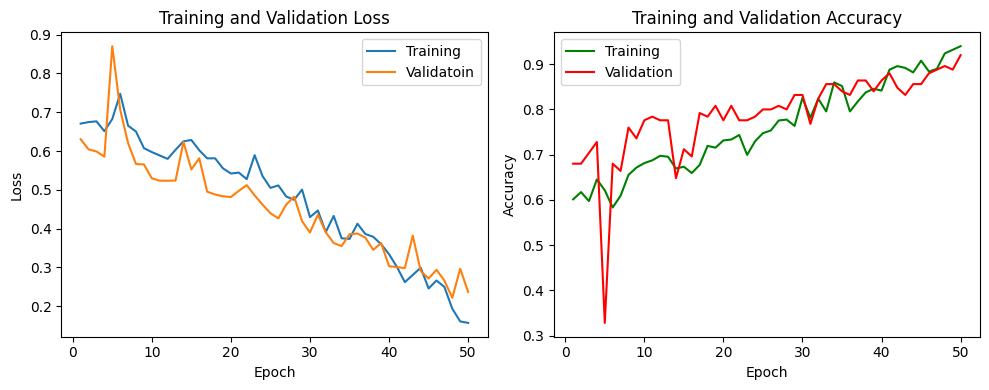

In [6]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_R.parameters(), lr=0.001, momentum=0.9)


num_epochs = 50
training_loss = []  
validation_loss = []
train_acc = []
validatoin_acc = []

#Training

for epoch in range(num_epochs):
    model_R.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_R(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_accuary = train_correct / train_total
    training_loss.append(train_loss)
    train_acc.append(train_accuary)


#Validation

    model_R.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for i,data in enumerate(val_loader,0):
            inputs,labels = data
            outputs = model_R(inputs)
            val_loss = criterion(outputs,labels)
            running_val_loss += val_loss.item()

            _,predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    validation_loss.append(val_loss)
    validatoin_acc.append(val_accuracy)
    

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuary*100:.2f}%, Validatoin Loss: {val_loss:.4f}, Validatoin Accuracy: {val_accuracy*100:.2f}%")


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_loss,label = 'Training')
plt.plot(range(1, num_epochs + 1), validation_loss,label = 'Validatoin')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc,color='g',label = 'Training')
plt.plot(range(1, num_epochs + 1), validatoin_acc,color='r',label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

AUROC: 0.9647


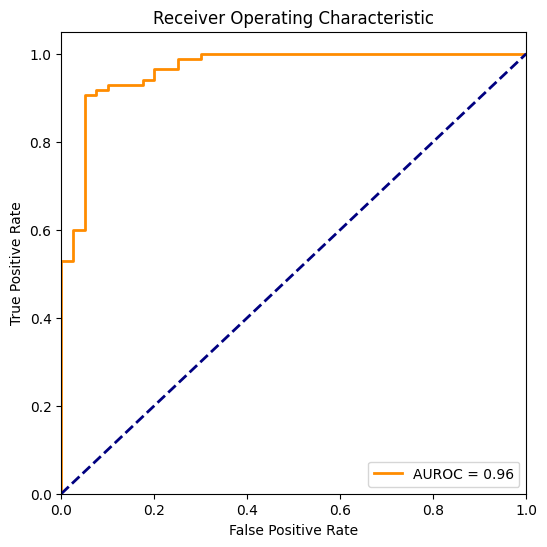

In [8]:
model_R.eval()
all_labels = []  # 存储所有验证集的真实标签
all_scores = []  # 存储所有验证集的模型输出概率分数

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        outputs = model_R(inputs)

        all_labels.extend(labels.cpu().numpy())  # 将真实标签添加到列表
        all_scores.extend(outputs[:, 1].cpu().numpy())  # 将模型输出的概率分数添加到列表

# 5. 计算 ROC 曲线和 AUROC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
auroc = auc(fpr, tpr)

print(f"AUROC: {auroc:.4f}")

# 6. 绘制 ROC 曲线
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [9]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_R.to(device)
# data_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
# train_data = datasets.ImageFolder('/home/john/network/RETFound/RETFound_MAE-main/data/', transform=data_transform)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)


# criterion = nn.CrossEntropyLoss()
# criterion = criterion.to(device)
# optimizer = optim.SGD(model_R.parameters(), lr=0.001, momentum=0.9)


# num_epochs = 200
# losses = []  
# accuracies = []  

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model_R(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     epoch_loss = running_loss / len(train_loader)
#     epoch_accuracy = correct / total
#     losses.append(epoch_loss)
#     accuracies.append(epoch_accuracy)

#     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%")


# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, num_epochs + 1), losses, marker='o')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

# plt.subplot(1, 2, 2)
# plt.plot(range(1, num_epochs + 1), accuracies, marker='o', color='g')
# plt.title('Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

# plt.tight_layout()
# plt.show()
